In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np

##### Ordinary differential equations
ODE: Defined by a vector field $u_t(X_t): \mathbb{R}^d\times[0,1] \rightarrow \mathbb{R}^d,  (x,t)\rightarrow u_t(x)$, which imposes a condition on it's solution.

Trajectory: solution to an ODE from a given initial condition i.e. solution to the equation

$$
\begin{aligned}
&\frac{d}{dt}X_t=u_t(X_t),
\\
&X_0=x_0
\end{aligned}
$$

Flow: collection of trajectories from multiple initial conditions, i.e. for an initial condition and time, the flow gives the value of the trajectory from that initial point at the given time.

$$
\psi: \mathbb{R}^d\times[0,1]\rightarrow\mathbb{R}^d,  (X_0,t)\rightarrow\psi_t(X_0)
$$



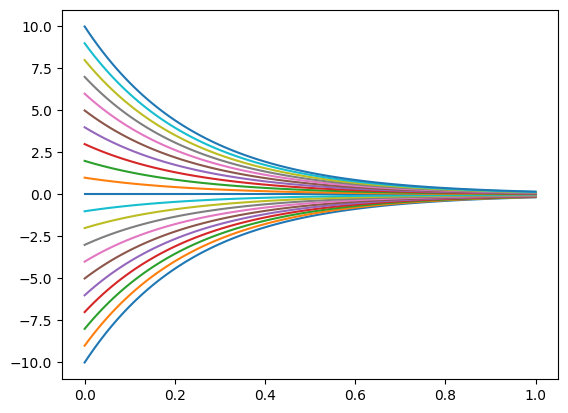

In [4]:
# Euler method simulation of a linear ODE: x' = -ax, a > 0 e.g. a = 4, with flow x(t) = x0*exp(-at)

# Define the ODE vector field fn
def u(x, t):
  return -4*x

x0s = jnp.arange(-10., 11., 1.)

n_steps = 100
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)

def euler_step(x, t, h):
  x_th = x + h*u(x, t)
  return x_th, x_th

def trajectory(x0):
  return jax.lax.scan(lambda x, t: euler_step(x, t, h), x0, ts[1:])[1]

flow = jax.lax.concatenate([
  x0s[:, None],
  jax.vmap(trajectory)(x0s)
], 1)

# plot the flow

plt.plot(ts, flow.T)
plt.show()


(101, 21)


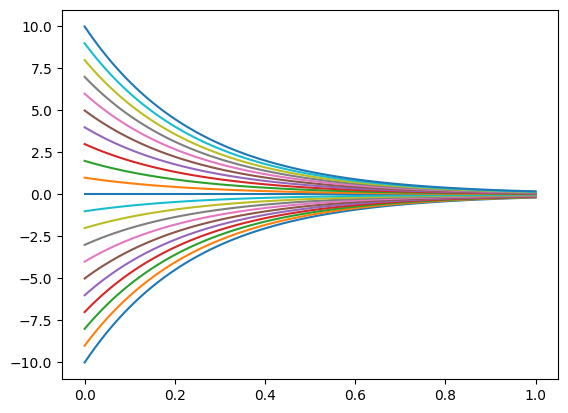

In [5]:
def soln(t, x0):
  return x0*jnp.exp(-4*t)

flow = jax.vmap(soln, in_axes=(0, None))(ts, x0s)
print(flow.shape)

plt.plot(ts, flow)
plt.show()

##### Flow model

Generative model that z_data from the data distribution $p_{data}$ by using the simulation of an ODE to transform a simple distribution $p_{init}$ (e.g. Gaussian) to the complex distribution $p_{data}$. Model is described by the ODE below, where the vector field $u_t^{\theta}(X_t)$ is a neural network with parameters $\theta$.

$$
\begin{aligned}
&X_0\sim p_{init}
\\
&\frac{d}{dt}X_t=u_t^{\theta}(X_t),
\end{aligned}
$$

Simulating the ODE gives the flow $\psi_1^{\theta}$ induced by the vector field $u_t^{\theta}$. The endpoint $X_1\sim p_{data} \Leftrightarrow \psi_1^{\theta}(X_0)\sim p_{data}$.

##### Stochastic differential equations
SDE: Defined by a vector field $u_t(X_t): \mathbb{R}^d\times[0,1] \rightarrow \mathbb{R}^d,  (x,t)\rightarrow u_t(x)$, and a diffusion coefficient $\sigma_t: [0,1]\rightarrow\mathbb{R}_{\ge 0}$

Solution to SDE from a given initial condition is a stochastic process, a collection of random variables indexed by time $(X_t)_{0\ge t\ge 1}$ i.e. a collection (or probabilities) of random trajectories that are solutions to the equation,

$$
\begin{aligned}
&dX_t=u_t(X_t)dt+\sigma_t dW_t,
\\
&X_0=x_0
\end{aligned}
$$

$dW_t$ are infinitesimal Brownian motion increments. Brownian motion/Wiener process is a stochastic process $(W_t)_{0\ge t\ge 1}$ such that: $W_0=0$, the trajectories $t\rightarrow W_t$ are continuous and have Normal, independent increments, $W_{t+h}-W_t\sim \mathcal{N}(0,hI)$.

SDEs do not have a flow map $\psi_t$ since $X_t$ is stochastic and not fully determined by $X_0\sim p_{init}$.



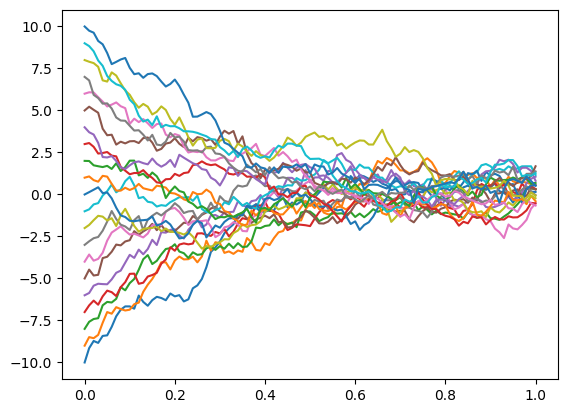

In [6]:
# Simulation of SDE (Ornstein-Uhlenbeck process: dX_t = -aX_t dt + sdW_t, a > 0) using Euler-Maruyama method

rng_key = jax.random.PRNGKey(0)

# TODO: sample random increments e from a normal distribution outside the step function

es_all = jax.random.normal(rng_key, (x0s.shape[0], n_steps))

s = 3.0

def euler_maruyama_step(x, te, h, s):
  t, e = te
  dw = jnp.sqrt(h)*e
  x_th = x - 4*x*h + s*dw
  return x_th, x_th

def trajectory(x0, es):
  return jax.lax.scan(lambda x, te: euler_maruyama_step(x, te, h, s), x0, (ts[1:], es))[1]

flow = jax.lax.concatenate([
  x0s[:, None],
  jax.vmap(trajectory)(x0s, es_all)
], 1)

plt.plot(ts, flow.T)
plt.show()

##### Diffusion model

Generative model that z_data from the data distribution $p_{data}$ by using the simulation of an SDE with initial conditions sampled from a simple distribution $X_0\sim p_{init}$. Model is described by the SDE below, where the vector field $u_t^{\theta}(X_t)$ is an NN, and the diffusion coeff $\sigma_t$ is typically fixed (but can also be parameterized).

$$
\begin{aligned}
&X_0\sim p_{init}
\\
&dX_t=u_t^{\theta}(X_t)dt + \sigma_t dW_t,
\end{aligned}
$$

Simulating the SDE gives the endpoint (a realization of a random variable) $X_1\sim p_{data}$.

Probability paths

**Conditional prob path**: $p_t(\cdot|z)$, path of prob distributions $p_t(\cdot|z)$ conditional on a given data sample $z$ such that: 

1. $p_0(\cdot|z)\sim p_{init}$ 
2. $p_1(\cdot|z)\sim \delta_z$.

i.e. compresses an initial distribution $p_{init}$ (typically noise/Gaussian) into a dirac distribution at the given sample.

e.g. $p_t(\cdot|z)=\mathcal{N}(\alpha_t z, \beta_t^2 I_d)$ where $\alpha_t=t, \beta_t=(1-t)$ are noise schedules, known as the *CondOT path* (conditional optimal transport path).
  
**Marginal prob path**: $p_t(\cdot)$, prob paths $p_t(\cdot|z)$ for any data sample i.e. marginalizing $z\sim p_{data}$ from the joint distribution $p_t(\cdot|z)p_{data}$. 

1. $p_t(\cdot)=\int{p_t(\cdot|z)p_{data}dz}$
2. $p_0(\cdot)=p_{init}$
3. $p_1(\cdot)=p_{data}$

i.e. transforms an initial distribution to the data distribution.

Practically, sample $z\sim p_{data}, x\sim p_t(\cdot|z) \Rightarrow x\sim p_t(\cdot)$



![alt text](prob-path.jpg "prob path")

Vector fields

**Conditional vector field**: $u_t^{target}(x|z)$ vector field conditional on a sample that characterizes the ODE that follows along the corresponding conditional prob path $p_t(\cdot|z)$. This ODE is such that:

1. $X_0\sim p_{init}$
2. $\frac{d}{dt}X_t=u_t^{target}(X_t|z) \Rightarrow X_t\sim p_t(\cdot|z)$
3. $ X_1\sim \delta_z\ $

For a Gaussian vector field: $u_t^{target}(x|z)=\left(\dot{\alpha_t}-\frac{\dot{\beta_t}}{\beta_t}\alpha_t\right)z+\frac{\dot{\beta_t}}{\beta_t}x$, for the linear noise schedules $\dot{\alpha_t}=\frac{d}{dt}\alpha_t=1, \dot{\beta_t}=-1$, $u_t^{target}(x|z)=\left(1+\frac{\alpha_t}{\beta_t}\right)z-\frac{1}{\beta_t}x$
1. at $t=0, (\alpha_t=0, \beta_t=1) \Rightarrow u_0(x|z)=z-x$.
2. as $t\rightarrow 1, (\alpha_t\rightarrow 1, \beta_t \rightarrow 0) \Rightarrow u_0(x|z)\approx\hat{\alpha}_t\cdot(z-x), \hat{\alpha}_t\rightarrow \infty$

i.e. conditional vector field 'pushes' every point in the space towards the sample $z$ in steps that grow as $\approx\frac{1}{1-t}$


#### Flow model ODEs

**Marginal vector field**: $u_t^{target}(x)$, by the *marginalization trick*:
$$
u_t^{target}(x)=\mathbb{E}_{z\sim p_t(z|x)}[u_t^{target}(x|z)]=\int{u_t^{target}(x|z)p_t(z|x)dz}=\int{u_t^{target}(x|z)\frac{p_t(x|z)p_{data}(z)}{p_t(x)}dz}
$$
The marginal vector field characterizes an ODE such that:
1. $X_0\sim p_{init}$
2. $\frac{d}{dt}X_t=u_t^{target}(X_t) \Rightarrow X_t\sim p_t(\cdot)$
3. $ X_1\sim p_{data}\ $


*How to get the conditional vector field for an arbitrary choice of cond prob path?* Derive from continuity equation,

**Continuity equation**: Change of prob mass at x = Outflow-inflow (divergence) of prob mass from u. $\frac{d}{dt}p_t(x)=-div(p_t\cdot u_t)(x), div(f)(x)=\sum_{i=1}^d\frac{d}{dx_i}f(x)$


![alt text](cond_vector_field.jpg "cond vector field")

![alt text](marg_vector_field.jpg "cond vector field")

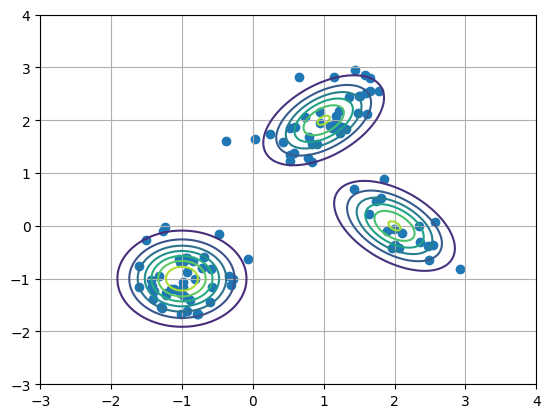

In [7]:
# Example with data from mixture of 3 2d Gaussians with diff var-covar matrices
# true data distribution params: 
true_mus = -1+jnp.array([[0., 0.], [2., 3.], [3., 1.]])
true_covs = 0.2*jnp.array([[[1., 0.], [0., 1.]], [[1., 0.5], [0.5, 1.]], [[1., -0.5], [-0.5, 1.]]])
true_pis = jnp.array([0.3, 0.5, 0.2])

n_samples = 100

rng_key = jax.random.PRNGKey(0)

def sample_mixture(rng_key, n_samples):
  rng_key, subkey = jax.random.split(rng_key)
  k = jax.random.choice(subkey, jnp.arange(3), p=true_pis, shape=(n_samples,))
  rng_key, subkey = jax.random.split(rng_key)
  return jax.random.multivariate_normal(subkey, true_mus[k], true_covs[k])

z_data = sample_mixture(rng_key, n_samples)

# plot the z_data
plt.scatter(z_data[:, 0], z_data[:, 1])

# plot the true mixture component contours
for i in range(3):
  x = jnp.linspace(true_mus[i][0] - 2, true_mus[i][0] + 2, 100)
  y = jnp.linspace(true_mus[i][1] - 2, true_mus[i][1] + 2, 100)
  X, Y = jnp.meshgrid(x, y)
  Z = jax.scipy.stats.multivariate_normal.pdf(jnp.stack([X, Y], -1), true_mus[i], true_covs[i])
  plt.contour(X, Y, Z)

plt.grid()
plt.show()

In [8]:
def cond_prob_path(z, t, x):
  t = jnp.clip(t, 0., 1.)
  a_t = t
  b_t = (1-t)
  return jax.scipy.stats.multivariate_normal.pdf(x, a_t*z, b_t*jnp.eye(2))

def cond_vec_field(z, t, x):
  # for a Gaussian cond prob path
  t = jnp.clip(t, 0., 1.)
  a_t = t
  b_t = (1-t)
  return z + ((a_t*z - x)/b_t)

init_mu = jnp.array([0., 0.])
init_cov = jnp.eye(2)

n_steps = 10
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)

def euler_step(x, t, h, z):
  x_th = x + h*cond_vec_field(z, t, x)
  return x_th, x_th

def trajectory(x0, z):
  return jax.lax.scan(lambda x, t: euler_step(x, t, h, z), x0, ts[1:])[1]

z_data_sample = z_data[0]

x0s = jax.random.multivariate_normal(rng_key, init_mu, init_cov, (100,))

flow = jax.vmap(trajectory, in_axes=(0, None))(x0s, z_data_sample)

flow = jnp.concatenate([x0s[:, None], flow], 1)
flow.shape


(100, 11, 2)

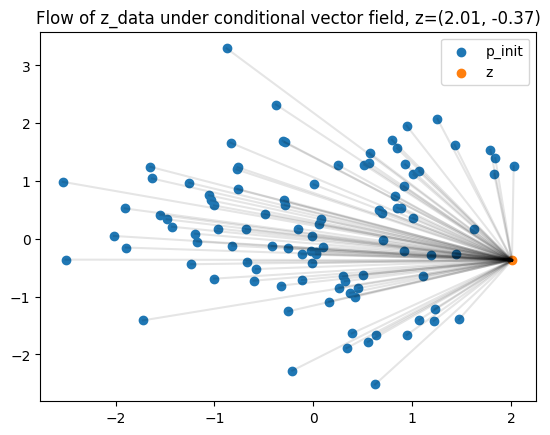

In [9]:
plt.scatter(x0s[:, 0], x0s[:, 1], label='p_init')
plt.scatter(*z_data_sample, label='z')
# line plot of the flow
plt.plot(flow[:, :, 0].T, flow[:, :, 1].T, color='black', alpha=0.1)
plt.legend()
plt.title('Flow of z_data under conditional vector field, z=({:.2f}, {:.2f})'.format(*z_data_sample))
plt.show()

In [10]:
# marginal prob under data distribution
def marginal_prob_path(x, t, z_data):
  return jnp.mean(jax.vmap(lambda z: cond_prob_path(z, t, x), in_axes=0)(z_data), 0)

def marginal_vec_field(x, t, z_data):
  p_t_x = marginal_prob_path(x, t, z_data)
  p_data_z = 1/z_data.shape[0]
  return (p_data_z/p_t_x)*jnp.sum(jax.vmap(lambda z: cond_vec_field(z, t, x) * cond_prob_path(z, t, x), in_axes=0)(z_data), 0)

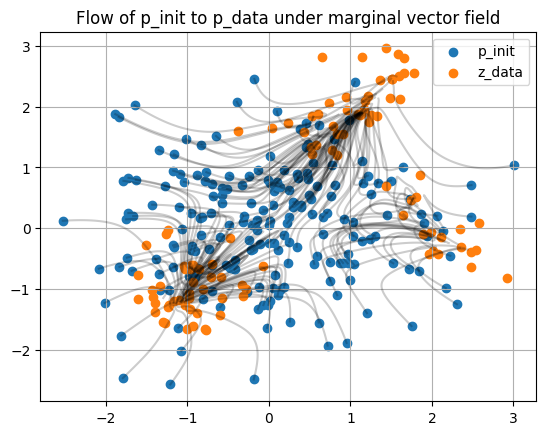

In [67]:
n_steps = 100
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)
# ts = ts.at[-1].set(ts[-1] - 1e-3)

def euler_step(x, t, h, z_data):
  x_th = x + h*marginal_vec_field(x, t, z_data)
  return x_th, x_th

def trajectory(x0, z_data):
  return jax.lax.scan(lambda x, t: euler_step(x, t, h, z_data), x0, ts[:-1])[1]

x0s = jax.random.multivariate_normal(rng_key, init_mu, init_cov, (200,))

#uniform grid btwn -2, 6
# x0s = jnp.array([[i, j] for i in jnp.linspace(-2, 6, 10) for j in jnp.linspace(-2, 6, 10)])

flow = jax.vmap(trajectory, in_axes=(0, None))(x0s, z_data)
flow = jnp.concatenate([x0s[:, None], flow], 1)

plt.scatter(x0s[:, 0], x0s[:, 1], label='p_init')
plt.plot(flow[:, :, 0].T, flow[:, :, 1].T, color='black', alpha=0.2)
plt.scatter(z_data[:, 0], z_data[:, 1], label='z_data')
plt.legend()
plt.grid()
plt.title('Flow of p_init to p_data under marginal vector field')
plt.show()

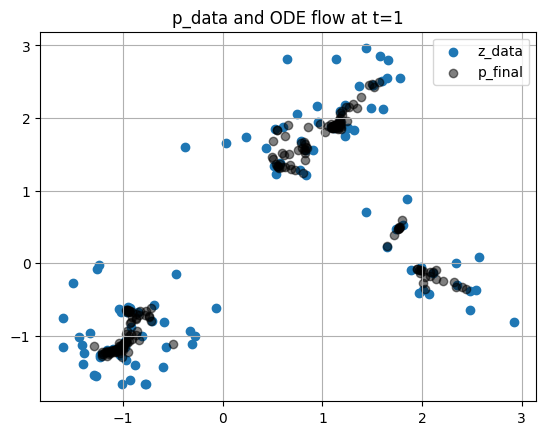

In [68]:
plt.scatter(z_data[:, 0], z_data[:, 1], label='z_data')
plt.scatter(flow[:, -1, 0].T, flow[:, -1, 1].T, color='black', alpha=0.5, label='p_final')

plt.legend()
plt.grid()

plt.title('p_data and ODE flow at t=1')
plt.show()

#### Extension to SDEs (Diffusion model)

Score functions

**Conditional score function**: $\nabla_x \log p_t(x|z)$

For a Gaussian cond prob path: $\nabla_x \log p_t(x|z) = - \frac{x-\alpha_t z}{\beta_t^2}$

**Marginal score function**: 
$$
\nabla_x \log p_t(x) = \frac{\nabla_x p_t(x)}{p_t(x)} = \frac{\nabla_x \int{p_t(x|z)p_{data}dz}}{p_t(x)} = \int{\nabla_x p_t(x|z)\frac{p_{data}(z)}{p_t(x)}dz} = \int{\nabla_x\log{p_t(x|z)} \frac{p_t(x|z)p_{data}(z)}{p_t(x)}dz}
$$

For any diffusion coeff $\sigma_t \ge 0$, the SDE below follows the same marginal prob path

$$
\begin{aligned}
&X_0\sim p_{init}
\\
&dX_t=\left[u_t^{target}(X_t)+\frac{\sigma_t^2}{2}\nabla_x \log{p_t(X_t)}\right]dt+\sigma_t dW_t &\Rightarrow X_t\sim p_t(x)
\\
&X_1\sim p_{data}
\end{aligned}
$$

In [17]:
def cond_score_fn(z, t, x):
  # for a Gaussian cond prob path
  t = jnp.clip(t, 0., 1.)
  a_t = t
  b_t = (1-t)
  return -(x - a_t*z)/jnp.square(b_t)


def marginal_score_fn(x, t, z_data):
  p_t_x = marginal_prob_path(x, t, z_data)
  p_data_z = 1/z_data.shape[0]
  return (p_data_z/p_t_x)*jnp.sum(jax.vmap(lambda z: cond_score_fn(z, t, x) * cond_prob_path(z, t, x), in_axes=0)(z_data), 0)

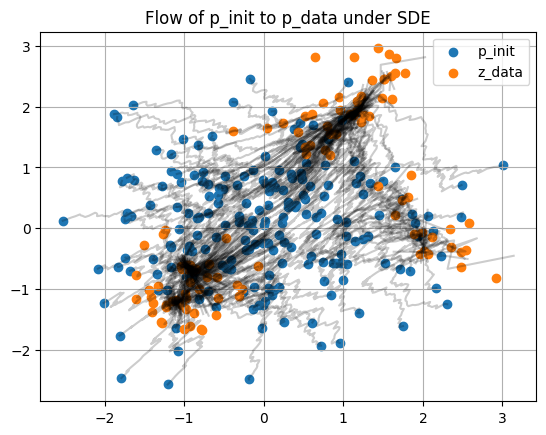

In [62]:
n_steps = 100
h = 1/n_steps
ts = jnp.arange(0, 1+h, h)
ts = ts.clip(0., 0.99)

x0s = jax.random.multivariate_normal(rng_key, init_mu, init_cov, (200,))

es_all = jax.random.normal(rng_key, (x0s.shape[0], n_steps)) # sample random increments e from a normal distribution outside the step function

sigma_t = 0.3

def euler_maruyama_step(x, te, h, z_data, sigma_t):
  # dX = [u_t(X) + sigma_t/2 * grad_x log p_t(X)]dt + sigma_t dW
  t, e = te
  dw = jnp.sqrt(h)*e
  x_th = x + h*(
    marginal_vec_field(x, t, z_data) + (jnp.square(sigma_t)/2)*marginal_score_fn(x, t, z_data)
  ) + sigma_t*dw
  return x_th, x_th


def trajectory(x0, es, z_data):
  return jax.lax.scan(lambda x, te: euler_maruyama_step(x, te, h, z_data, sigma_t), x0, (ts[1:], es))[1]
  
flow = jax.vmap(trajectory, in_axes=(0, 0, None))(x0s, es_all, z_data)
flow = jnp.concatenate([x0s[:, None], flow], 1)

plt.scatter(x0s[:, 0], x0s[:, 1], label='p_init')
plt.plot(flow[:, :, 0].T, flow[:, :, 1].T, color='black', alpha=0.2)
plt.scatter(z_data[:, 0], z_data[:, 1], label='z_data')
plt.legend()
plt.grid()
plt.title('Flow of p_init to p_data under SDE')
plt.show()

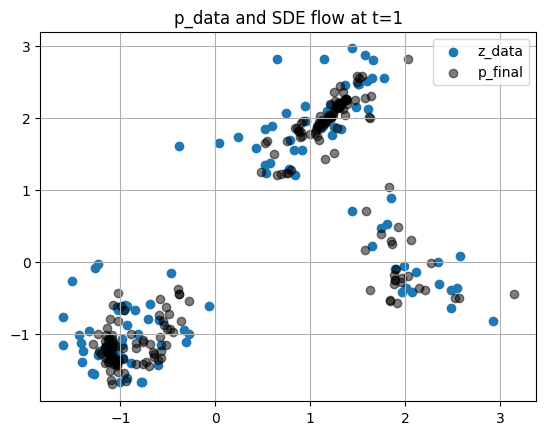

In [65]:
plt.scatter(z_data[:, 0], z_data[:, 1], label='z_data')
plt.scatter(flow[:, -1, 0].T, flow[:, -1, 1].T, color='black', alpha=0.5, label='p_final')

plt.legend()
plt.grid()

plt.title('p_data and SDE flow at t=1')
plt.show()